s
s
s
s
s
s
npe           n=20000  q05=0.000  q50=0.000  q95=0.000
rnpe          n=20000  q05=1.027  q50=1.579  q95=3.379
pnpe          n=20000  q05=0.358  q50=0.358  q95=0.358
prnpe         n=20000  q05=0.676  q50=0.762  q95=0.862
rf_abc_npe    n=20000  q05=0.992  q50=1.018  q95=1.042
rf_abc_rnpe   n=20000  q05=0.678  q50=0.746  q95=0.807


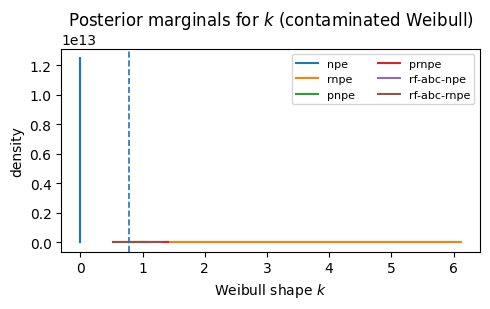

In [5]:
from __future__ import annotations
from pathlib import Path
import re, numpy as np
import matplotlib.pyplot as plt

# --- config ---
RESULTS_ROOT = Path("../results/hpc/contaminated_weibull")  # adjust if needed
GROUP = "th_k0.8-n_obs_200-obs_true-eps_0.05-alpha_40.0-n_sims_20000"
SEED = 0
K_STAR_OVERRIDE: float | None = None  # set to e.g. 0.789 to override parsed value

# Known method folders; any missing are silently skipped.
METHOD_DIRS = [
    "npe",
    "rnpe",
    "pnpe",
    "prnpe",
    "rf_abc_npe",
    "rf_abc_rnpe",
]


def parse_k_star(group: str) -> float | None:
    m = re.search(r"th_k([0-9]*\.?[0-9]+)", group)
    return float(m.group(1)) if m else None


def latest_timestamp_dir(p: Path) -> Path | None:
    cand = [
        d for d in p.iterdir() if d.is_dir() and re.fullmatch(r"\d{8}-\d{6}", d.name)
    ]
    return max(cand, key=lambda d: d.stat().st_mtime) if cand else None


def load_k_samples(npz_path: Path) -> np.ndarray:
    with np.load(npz_path, allow_pickle=True) as data:
        for key in ("k", "theta", "thetas", "posterior_samples", "samples", "params"):
            if key in data:
                arr = np.asarray(data[key])
                break
        else:
            arr = np.asarray(next(iter(data.values())))
    arr = np.asarray(arr)
    if arr.ndim == 1:
        return arr.astype(float)
    # assume last dim indexes parameters; take the first as k
    return arr.reshape(-1, arr.shape[-1])[:, 0].astype(float)


def histogram_line(x: np.ndarray, bins: int = 128):
    counts, edges = np.histogram(x, bins=bins, density=True)
    return 0.5 * (edges[1:] + edges[:-1]), counts


# k_star = K_STAR_OVERRIDE if K_STAR_OVERRIDE is not None else parse_k_star(GROUP)
k_star = 0.789

k_by_method: dict[str, np.ndarray] = {}
for mdir in METHOD_DIRS:
    base = RESULTS_ROOT / mdir / GROUP / f"seed-{SEED}"
    if not base.exists():
        print("aa")
        continue
    run = latest_timestamp_dir(base)
    if run is None:
        continue
    f = run / "posterior_samples.npz"
    if not f.exists():
        f = run / "posterior_samples_robust.npz"
        # continue
    try:
        k_by_method[mdir] = load_k_samples(f)
        print("s")
    except Exception as e:
        print(f"[skip] {mdir}: {e}")

# --- sanity print ---
for name, ks in k_by_method.items():
    q = np.quantile(ks, [0.05, 0.5, 0.95])
    print(f"{name:12s}  n={len(ks):5d}  q05={q[0]:.3f}  q50={q[1]:.3f}  q95={q[2]:.3f}")

# --- plot ---
plt.figure(figsize=(5.0, 3.2))
for name, ks in k_by_method.items():
    x, y = histogram_line(ks, bins=128)
    plt.plot(x, y, label=name.replace("_", "-"))
if k_star is not None:
    plt.axvline(k_star, linestyle="--", linewidth=1.2)
plt.xlabel("Weibull shape $k$")
plt.ylabel("density")
plt.title("Posterior marginals for $k$ (contaminated Weibull)")
plt.legend(fontsize=8, ncol=2)
Path("figures").mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig("figures/weibull_k_posteriors.pdf", bbox_inches="tight")
plt.savefig("figures/weibull_k_posteriors.png", bbox_inches="tight", dpi=300)
plt.show()

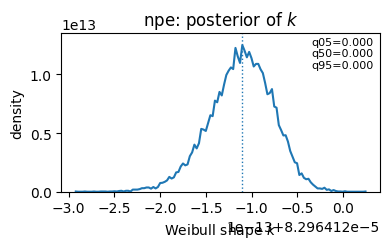

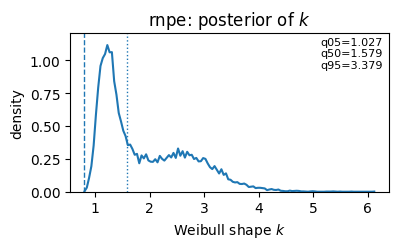

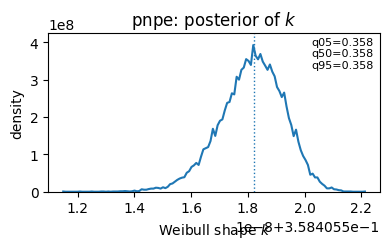

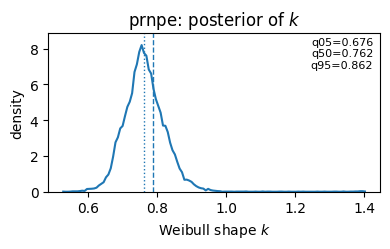

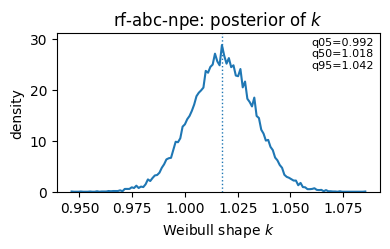

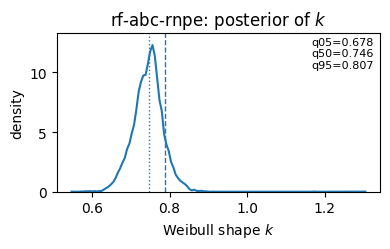

In [6]:
# --- per-method figures (independent axes) ---
outdir = Path("figures/k_by_method")
outdir.mkdir(parents=True, exist_ok=True)
k_star = 0.789
if not k_by_method:
    print("No posterior samples found.")
else:
    for name, ks in k_by_method.items():
        x, y = histogram_line(ks, bins=128)
        q05, q50, q95 = np.quantile(ks, [0.05, 0.5, 0.95])

        # per-figure limits
        xmin, xmax = float(x.min()), float(x.max())
        xpad = 0.05 * (xmax - xmin if xmax > xmin else 1.0)
        ymin, ymax = 0.0, float(y.max())
        ypad = 0.08 * (ymax if ymax > 0 else 1.0)

        plt.figure(figsize=(4.0, 2.6))
        plt.plot(x, y)
        if k_star is not None:
            plt.axvline(k_star, linestyle="--", linewidth=1.0)
        plt.axvline(q50, linestyle=":", linewidth=1.0)

        plt.xlabel("Weibull shape $k$")
        plt.ylabel("density")
        plt.title(f"{name.replace('_','-')}: posterior of $k$")
        plt.xlim(xmin - xpad, xmax + xpad)
        plt.ylim(ymin, ymax + ypad)
        plt.text(
            0.98,
            0.98,
            f"q05={q05:.3f}\nq50={q50:.3f}\nq95={q95:.3f}",
            transform=plt.gca().transAxes,
            ha="right",
            va="top",
            fontsize=8,
        )
        plt.tight_layout()
        stem = f"weibull_k_{name}"
        plt.savefig(outdir / f"{stem}.pdf", bbox_inches="tight")
        plt.savefig(outdir / f"{stem}.png", bbox_inches="tight", dpi=300)
        plt.show()

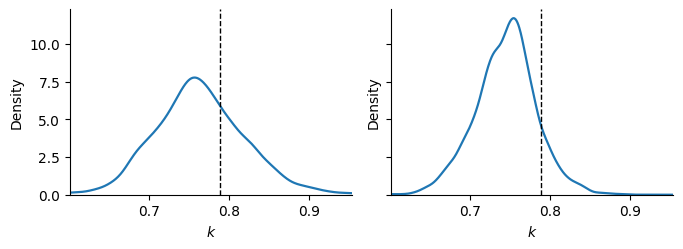

In [7]:
# %% Figure 1 — Posterior for k (PRNPE preconditioners; two panels, shared axes)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# --- config (edit if needed) ---
LABELS = {"prnpe": "PRNPE–SMC‑ABC", "rf_abc_rnpe": "PRNPE–Random‑Forest"}
PRIOR_MU, PRIOR_SIGMA = 1.0, 1.0  # LogNormal prior on k
SAVE_SPLIT = False  # also save one‑panel versions if True


# --- helpers ---
def hpd_interval(x: np.ndarray, mass: float = 0.95) -> tuple[float, float]:
    x = np.sort(np.asarray(x, float))
    n = x.size
    m = max(1, int(np.floor(mass * n)))
    widths = x[m:] - x[: n - m]
    i = int(np.argmin(widths))
    return float(x[i]), float(x[i + m])


def kde1d(samples: np.ndarray, grid: np.ndarray, bw: float | None = None) -> np.ndarray:
    s = np.asarray(samples, float)
    s = s[np.isfinite(s)]
    n = s.size
    if n == 0:
        return np.zeros_like(grid)
    if bw is None:
        sd = np.std(s, ddof=1) if n > 1 else 1.0
        bw = 1.06 * sd * n ** (-1 / 5) or 1e-3
    z = (grid[None, :] - s[:, None]) / bw
    return np.exp(-0.5 * z * z).sum(0) / (n * bw * np.sqrt(2 * np.pi))


def lognormal_pdf(x: np.ndarray, mu: float, sigma: float) -> np.ndarray:
    x = np.asarray(x, float)
    out = np.zeros_like(x)
    m = x > 0
    z = (np.log(x[m]) - mu) / sigma
    out[m] = np.exp(-0.5 * z * z) / (x[m] * sigma * np.sqrt(2 * np.pi))
    return out


def plot_panel(
    ax,
    ks: np.ndarray,
    title: str,
    xlim: tuple[float, float],
    k_star_line: float | None,
    clean_k_line: float | None,
    ymax: float,
):
    grid = np.linspace(*xlim, 600)
    dens = kde1d(ks, grid)
    ax.plot(grid, dens, linewidth=1.6)
    # prior outline
    # ax.plot(
    #     grid, lognormal_pdf(grid, PRIOR_MU, PRIOR_SIGMA), linewidth=0.9, linestyle="--"
    # )
    # vertical refs
    ax.axvline(0.789, linestyle="--", color="black", linewidth=1.0)
    # if k_star_line is not None:
    #     ax.axvline(k_star_line, linestyle=":", linewidth=1.2)
    # if clean_k_line is not None:
    #     ax.axvline(clean_k_line, linestyle="--", linewidth=1.0)
    # HPDI bars beneath x‑axis
    lo95, hi95 = hpd_interval(ks, 0.95)
    lo50, hi50 = hpd_interval(ks, 0.50)
    y95, y50 = -0.12 * ymax, -0.06 * ymax
    # ax.plot([lo95, hi95], [y95, y95], linewidth=1.2)
    # ax.plot([lo50, hi50], [y50, y50], linewidth=2.2)
    # numeric summary
    mean = float(np.mean(ks))
    # ax.text(
    #     0.98,
    #     0.97,
    #     f"mean={mean:.3f}\n50% [{lo50:.3f}, {hi50:.3f}]\n95% [{lo95:.3f}, {hi95:.3f}]",
    #     transform=ax.transAxes,
    #     ha="right",
    #     va="top",
    #     fontsize=8,
    # )
    # ax.set_title(title, fontsize=10)
    ax.set_xlim(*xlim)
    ax.set_ylim(0, 1.05 * ymax)


# --- select methods and make figure ---
needed = ["prnpe", "rf_abc_rnpe"]
avail = {k: v for k, v in k_by_method.items() if k in needed and len(v) > 0}
if set(needed) - set(avail):
    missing = ", ".join(sorted(set(needed) - set(avail)))
    print(f"[Fig1] Missing methods: {missing}. Skipping.")
else:
    # references
    clean_k = parse_k_star(GROUP)
    k_star_line = K_STAR_OVERRIDE if (K_STAR_OVERRIDE is not None) else k_star

    # common x‑axis from combined posteriors (robust to outliers)
    both = np.concatenate([avail[m] for m in needed])
    lo, hi = np.quantile(both[np.isfinite(both)], [0.0025, 0.9975])
    xlim = (max(0.0, lo - 0.02 * (hi - lo)), hi + 0.02 * (hi - lo))

    # common y‑axis height
    grid = np.linspace(*xlim, 600)
    y_max = max(kde1d(avail[m], grid).max() for m in needed)

    fig, axes = plt.subplots(1, 2, figsize=(6.8, 2.6), sharex=True, sharey=True)
    for ax, key in zip(axes, needed):
        plot_panel(ax, avail[key], LABELS[key], xlim, k_star_line, clean_k, y_max)
        ax.set_xlabel("$k$")
        ax.set_ylabel("Density")
    # tidy and save
    for ax in axes:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    Path("figures").mkdir(parents=True, exist_ok=True)
    # fig.suptitle(
    #     "Posterior for $k$ with prior outline; bars: 50% (thick), 95% (thin). "
    #     f"Refs: $k^\\star$ (dotted){' and clean $k$ (dashed)' if clean_k is not None else ''}.",
    #     fontsize=9,
    #     y=1.02,
    # )
    fig.tight_layout()
    fig.savefig("figures/fig1_weibull_k_prnpe.pdf", bbox_inches="tight")
    # fig.savefig("figures/fig1_weibull_k_prnpe.png", dpi=300, bbox_inches="tight")
    plt.show()

    if SAVE_SPLIT:
        for key in needed:
            fig1, ax1 = plt.subplots(1, 1, figsize=(3.35, 2.6))
            plot_panel(ax1, avail[key], LABELS[key], xlim, k_star_line, clean_k, y_max)
            ax1.set_xlabel("$k$")
            ax1.set_ylabel("Density")
            for side in ["top", "right"]:
                ax1.spines[side].set_visible(False)
            fig1.tight_layout()
            stem = f"fig1_{key}"
            fig1.savefig(f"figures/{stem}.pdf", bbox_inches="tight")
            # fig1.savefig(f"figures/{stem}.png", dpi=300, bbox_inches="tight")
            plt.show()

obs_point (1.2208424541256593, 2.404790401623197)
obs_point (1.2208424541256593, 2.404790401623197)


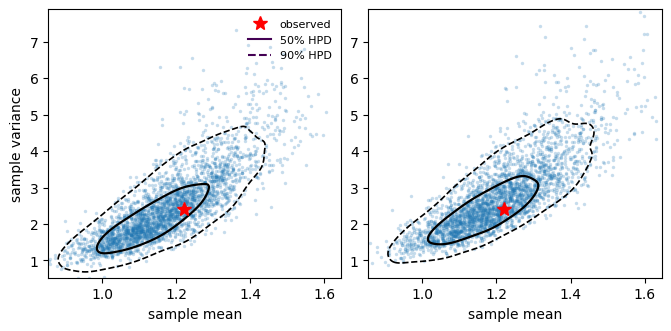

In [10]:
# === Figure 2: Posterior predictive for compatible summaries (mean, variance) ===
from __future__ import annotations
from pathlib import Path
import re, json, numpy as np
import matplotlib.pyplot as plt

# Optional KDE dependency
try:
    from scipy.stats import gaussian_kde

    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False
    from numpy.linalg import inv

# ------------------------------
# Config — adjust if needed
# ------------------------------
RESULTS_ROOT = Path("../results/hpc/contaminated_weibull")
GROUP = "th_k0.8-n_obs_200-obs_true-eps_0.05-alpha_40.0-n_sims_20000"
SEED = 0
N_PPC = 3000  # posterior predictive draws per method
N_OBS = 200  # dataset size per draw
SHOW_PRIOR = False  # optional faint prior-predictive contours
PRIOR_MU_SIGMA = (
    None  # e.g., (0.0, 0.9). If None and SHOW_PRIOR=True, defaults to (0.0, 0.9)
)

METHODS = {
    "PRNPE (SMC-ABC)": "prnpe",
    "PRNPE (Random-Forest)": "rf_abc_rnpe",
}

SAVE_STEM = "figures/weibull_ppc_two_methods"
Path("figures").mkdir(parents=True, exist_ok=True)

rng = np.random.default_rng(12345)


# ------------------------------
# Helpers (robust to varied file keys)
# ------------------------------

import numpy as np


def draw_hpd(ax, xi, yi, zi, levels, color="k"):
    levs = np.unique(np.sort(np.asarray(levels)))  # ensure strictly increasing
    if len(levs) == 1:
        # draw single contour if KDE collapsed
        ax.contour(xi, yi, zi, levels=[levs[0]], linewidths=1.6, linestyles="solid")
        return
    # levs[0] ≈ 90% (outer, lower density), levs[1] ≈ 50% (inner, higher density)
    ax.contour(
        xi, yi, zi, levels=[levs[0]], linewidths=1.2, linestyles="dashed", colors=color
    )
    ax.contour(
        xi, yi, zi, levels=[levs[1]], linewidths=1.6, linestyles="solid", colors=color
    )


def latest_timestamp_dir(p: Path) -> Path | None:
    cand = [
        d for d in p.iterdir() if d.is_dir() and re.fullmatch(r"\d{8}-\d{6}", d.name)
    ]
    return max(cand, key=lambda d: d.stat().st_mtime) if cand else None


def load_k_samples(npz_path: Path) -> np.ndarray:
    with np.load(npz_path, allow_pickle=True) as data:
        for key in ("k", "theta", "thetas", "posterior_samples", "samples", "params"):
            if key in data:
                arr = np.asarray(data[key])
                break
        else:
            arr = np.asarray(next(iter(data.values())))
    arr = np.asarray(arr)
    if arr.ndim == 1:
        ks = arr.astype(float)
    else:
        ks = arr.reshape(-1, arr.shape[-1])[:, 0].astype(float)
    ks = ks[np.isfinite(ks) & (ks > 0)]
    return ks


def _simulate_weibull_sample_mean_var(k: float, n_obs: int) -> tuple[float, float]:
    # Weibull(shape=k, scale=1): use inverse-CDF via Exp(1) or numpy's generator.
    # Use exponential transform for numerical parity with repo logic.
    e = rng.exponential(scale=1.0, size=n_obs)
    x = e ** (1.0 / k)  # scale=1
    return float(x.mean()), float(x.var(ddof=1))


def ppc_points_from_posterior(ks: np.ndarray, n_ppc: int, n_obs: int) -> np.ndarray:
    if len(ks) == 0:
        return np.zeros((0, 2))
    # sample posterior k's with replacement if needed
    idx = (
        rng.integers(0, len(ks), size=n_ppc)
        if len(ks) < n_ppc
        else rng.choice(len(ks), size=n_ppc, replace=False)
    )
    sel = ks[idx]
    means = np.empty(n_ppc, dtype=float)
    vars_ = np.empty(n_ppc, dtype=float)
    for i, k in enumerate(sel):
        m, v = _simulate_weibull_sample_mean_var(k, n_obs)
        means[i] = m
        vars_[i] = v
    # return as [mean, var]
    return np.column_stack([means, vars_])


def kde_levels(points: np.ndarray, mass=(0.5, 0.9), grid_size=200, pad=0.07):
    """
    Compute HPD contour levels via KDE. Returns (xi, yi, zi, levels_descending).
    If SciPy unavailable, falls back to Gaussian approximation using empirical mean/cov.
    """
    x = points[:, 0]
    y = points[:, 1]
    xq = np.quantile(x, [0.005, 0.995])
    yq = np.quantile(y, [0.005, 0.995])
    xr = xq[1] - xq[0]
    yr = yq[1] - yq[0]
    xmin, xmax = xq[0] - pad * xr, xq[1] + pad * xr
    ymin, ymax = yq[0] - pad * yr, yq[1] + pad * yr

    xi = np.linspace(xmin, xmax, grid_size)
    yi = np.linspace(ymin, ymax, grid_size)
    XX, YY = np.meshgrid(xi, yi)
    grid = np.vstack([XX.ravel(), YY.ravel()])

    if _HAS_SCIPY:
        kde = gaussian_kde(points.T, bw_method="scott")
        z = kde(grid).reshape(XX.shape)
        vals = kde(points.T)  # for HPD thresholds
        levels = [
            np.quantile(vals, 1.0 - m) for m in mass
        ]  # higher level => inner contour
        levels = sorted(levels, reverse=True)
        return xi, yi, z, levels, (xmin, xmax, ymin, ymax)
    else:
        # Gaussian fallback
        mu = points.mean(axis=0)
        Sigma = np.cov(points.T)
        iS = inv(Sigma)
        # Mahalanobis density proxy (monotone in quadratic form)
        diff = grid.T - mu
        q = np.einsum("ij,jk,ik->i", diff, iS, diff)
        z = (-0.5 * q).reshape(XX.shape)  # log-density up to constant
        # Map mass to chi-square quantiles with df=2
        from scipy.stats import (
            chi2,
        )  # try local import; if missing, replace with percentiles below

        try:
            radii = [chi2.ppf(m, df=2) for m in mass]
        except Exception:
            # percentile fallback using sample quadratic forms
            q_samp = np.einsum("ij,jk,ik->i", (points - mu), iS, (points - mu))
            radii = [np.quantile(q_samp, m) for m in mass]
        # Convert radii to equivalent z levels by evaluating on circle; monotonically related
        levels = sorted([-0.5 * r for r in radii], reverse=True)
        return xi, yi, z, levels, (xmin, xmax, ymin, ymax)


def load_run_dirs(method_dirname: str) -> tuple[Path, np.ndarray]:
    base = RESULTS_ROOT / method_dirname / GROUP / f"seed-{SEED}"
    run = latest_timestamp_dir(base)
    if run is None:
        raise FileNotFoundError(f"No run dir for {method_dirname}")
    # posterior samples
    f = run / "posterior_samples.npz"
    if not f.exists():
        f = run / "posterior_samples_robust.npz"
    ks = load_k_samples(f)
    return run, ks


s_obs = run / "s_obs.npy"

# ------------------------------
# Load data and build PPC points
# ------------------------------
ppc_by_method: dict[str, np.ndarray] = {}
obs_point: tuple[float, float] | None = None

for label, mdir in METHODS.items():
    run_dir, ks = load_run_dirs(mdir)
    # observed summaries: [var, mean, min]
    s_obs = np.load(run_dir / "s_obs.npy")
    obs_point = (float(s_obs[1]), float(s_obs[0]))  # (mean, variance)
    print("obs_point", obs_point)
    ppc_by_method[label] = ppc_points_from_posterior(ks, N_PPC, N_OBS)

# Global axis limits for comparability
all_pts = np.vstack(list(ppc_by_method.values()))
x_all, y_all = all_pts[:, 0], all_pts[:, 1]
xq = np.quantile(x_all, [0.005, 0.995])
yq = np.quantile(y_all, [0.005, 0.995])
xpad = 0.07 * (xq[1] - xq[0])
ypad = 0.07 * (yq[1] - yq[0])
X_LIM = (xq[0] - xpad, xq[1] + xpad)
Y_LIM = (yq[0] - ypad, yq[1] + ypad)

# Optional prior predictive overlay (same axes)
prior_grid = None
if SHOW_PRIOR:
    mu, sigma = PRIOR_MU_SIGMA if PRIOR_MU_SIGMA is not None else (0.0, 0.9)
    n_prior = 4000
    k_prior = np.exp(mu + sigma * rng.standard_normal(n_prior))
    prior_pts = np.column_stack(
        [_simulate_weibull_sample_mean_var(k, N_OBS) for k in k_prior]
    ).T
    prior_grid = kde_levels(prior_pts, mass=(0.5, 0.9))

# ------------------------------
# Plot
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(6.6, 3.2), constrained_layout=True)

for ax, (label, pts) in zip(axes, ppc_by_method.items()):
    # KDE grid and HPD levels
    xi, yi, zi, levels, _ = kde_levels(pts, mass=(0.5, 0.9))
    # Scatter PPC draws
    ax.scatter(pts[:, 0], pts[:, 1], s=6, alpha=0.25, linewidths=0)
    # ax.plot(obs_point)
    # HPD contours: 50% solid, 90% dashed
    draw_hpd(ax, xi, yi, zi, levels)

    # cs = ax.contour(
    #     xi, yi, zi, levels=levels, linewidths=(1.6, 1.2), linestyles=("solid", "dashed")
    # )
    # Optional prior overlay (faint)
    if prior_grid is not None:
        xi0, yi0, zi0, lev0, _ = prior_grid
        ax.contour(
            xi0,
            yi0,
            zi0,
            levels=[lev0[1]],
            linewidths=1.0,
            linestyles="dotted",
            alpha=0.6,
        )

    # Observed summaries
    ax.plot(
        obs_point[0],
        obs_point[1],
        marker="*",
        color="r",
        markersize=10,
        linestyle="None",
        label="observed",
    )
    # ax.set_title(label)
    ax.set_xlabel("sample mean")
    ax.set_xlim(*X_LIM)
    ax.set_ylim(*Y_LIM)
    if ax is axes[0]:
        ax.set_ylabel("sample variance")

# Legend proxy
axes[0].plot([], [], "-", color="#440154", label="50% HPD")
axes[0].plot([], [], "--", color="#440154", label="90% HPD")
if SHOW_PRIOR:
    axes[0].plot([], [], ":", label="prior 90%")
axes[0].legend(frameon=False, fontsize=8, loc="upper right")

# Save
plt.savefig(f"{SAVE_STEM}.pdf", bbox_inches="tight")
plt.savefig(f"{SAVE_STEM}.png", bbox_inches="tight", dpi=300)
plt.show()